End-to-End Machine Learning Pipeline
- Description: Build a complete machine learning pipeline that includes data
preprocessing, model training, evaluation, and deployment. Use cross-validation
techniques and evaluate model performance through various metrics.
https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [1]:
from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart.csv


In [41]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import joblib

In [42]:
#read data
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [43]:
print(df.info())
print(df.describe())
print(df.isnull().sum())  # Check missing values
df['HeartDisease'].value_counts(normalize=True)  # Class balance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  1

,proportion
HeartDisease,
1,0.553377
0,0.446623


In [44]:
#preprocessing
# Map binary columns manually
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})

# Features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Define categorical and numeric features
binary_features = ['Sex', 'ExerciseAngina']
categorical_features = ['ChestPainType', 'ST_Slope', 'RestingECG']
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

# ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(drop=None, dtype=int), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
], remainder='passthrough')  # to keep binary_features as-is


In [45]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
#Build pipeline with rf
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [47]:
#Cross-validation to check baseline accuracy
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
print(f'Random Forest CV Accuracy: {cv_scores.mean():.4f}')

Random Forest CV Accuracy: 0.8556


In [48]:
#Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5]
}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best CV Accuracy: 0.8610


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84        82
           1       0.86      0.90      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Confusion Matrix:
 [[67 15]
 [10 92]]
ROC AUC Score: 0.9259923481587756


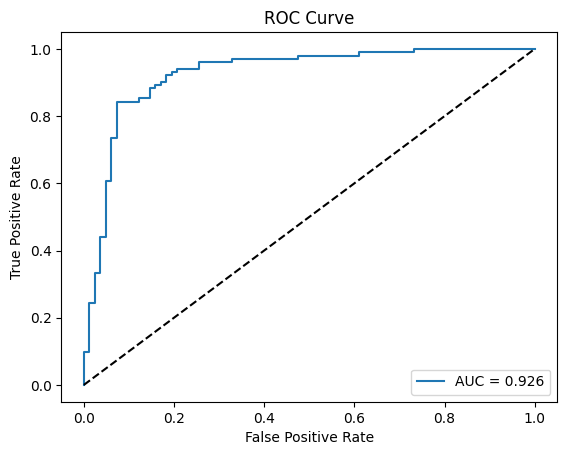

In [49]:
#Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [50]:
# Save the entire pipeline
joblib.dump(best_model, "heart_disease_pipeline.pkl")
print("Saved pipeline to heart_disease_pipeline.pkl")

Saved pipeline to heart_disease_pipeline.pkl


In [51]:
#Deployment helper function

def predict_heart_disease(input_df):
    """
    input_df: pd.DataFrame with same columns as training features (except target).
    Returns prediction and probability.
    """
    model = joblib.load("heart_disease_pipeline.pkl")
    pred = model.predict(input_df)
    proba = model.predict_proba(input_df)[:,1]
    return pred, proba

In [52]:
#Example:
new_patient = pd.DataFrame([{'Age': 55, 'Sex': 1, 'RestingBP': 130, 'Cholesterol': 230,
'FastingBS': 0, 'MaxHR': 150, 'ExerciseAngina': 0, 'Oldpeak': 1.0, 'ChestPainType': 'ATA', 'ST_Slope': 'Up', 'RestingECG': 'Normal'}])
pred, proba = predict_heart_disease(new_patient)
print("Prediction:", pred[0], "Probability of heart disease:", proba[0])

Prediction: 0 Probability of heart disease: 0.08093553295450093
